# Training the Prophet Model

reference : https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np
import joblib

c:\Users\amoza\anaconda3\envs\myprophet\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_DATA = '../data/'
PATH_MODEL = '../artifacts/'

In [3]:
def eval_ts(y_true, y_pred):
    eval_dict = {}
    eval_dict['mae'] = mean_absolute_error(y_true,y_pred)
    eval_dict['mape'] = mean_absolute_percentage_error(y_true,y_pred)
    eval_dict['mse'] = mean_squared_error(y_true,y_pred)
    eval_dict['rmse'] = np.sqrt(eval_dict['mse'])

    df_eval = pd.DataFrame([eval_dict]).transpose()
    df_eval.columns = ['Evaluations']

    return df_eval
    

In [4]:
## Ignore this for now
# import cmdstanpy
# cmdstanpy.install_cmdstan()
# cmdstanpy.install_cmdstan(compiler=True)

### Get Data

In [5]:
df_train = pd.read_csv(PATH_DATA + 'ts_train.csv')

In [6]:
df_train.head(8)

,Date,Temp
0,1987-01-01,12.3
1,1987-01-02,13.8
2,1987-01-03,15.3
3,1987-01-04,15.6
4,1987-01-05,16.2
5,1987-01-06,16.3
6,1987-01-07,16.8
7,1987-01-08,11.0


In [7]:
## Check the types again

df_train.dtypes

Date     object
Temp    float64
dtype: object

In [8]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [9]:
## Make Sure the date types
df_train.dtypes

Date    datetime64[ns]
Temp           float64
dtype: object

In [10]:
## Change columns name
df_train_ready = df_train.rename(columns={'Date':'ds', 'Temp':'y'})
df_train_ready.head()

,ds,y
0,1987-01-01,12.3
1,1987-01-02,13.8
2,1987-01-03,15.3
3,1987-01-04,15.6
4,1987-01-05,16.2


In [11]:
df_train['Date']

0      1987-01-01
1      1987-01-02
2      1987-01-03
3      1987-01-04
4      1987-01-05
          ...    
1090   1989-12-27
1091   1989-12-28
1092   1989-12-29
1093   1989-12-30
1094   1989-12-31
Name: Date, Length: 1095, dtype: datetime64[ns]

### Training the model

In [12]:
# setup the model
model_ts1 = Prophet()

In [13]:
# fit the model
model_ts1.fit(df_train_ready)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [14]:
## the variable model_ts1 is forecaster now
model_ts1

### Forecast on Train

it is called "In-Sample Forecast"

In [15]:
# get sample date from train --> all days in 1989
all_sample = df_train_ready[df_train_ready['ds']>='1989-01-01'].reset_index(drop=True)
date_of_all_sample = all_sample['ds']
df_date_sample = pd.DataFrame(date_of_all_sample)
df_date_sample

,ds
0,1989-01-01
1,1989-01-02
2,1989-01-03
3,1989-01-04
4,1989-01-05
...,...
360,1989-12-27
361,1989-12-28
362,1989-12-29
363,1989-12-30


In [16]:
## predict the sample
forecast = model_ts1.predict(df_date_sample)

In [17]:
## forecast is dataframe pandas with many columns in it
## just focus on this 4.
## yhat is the one point prediction, lower and upper is Confidence Interval
## Prediction must be a range, it depend on us how to present it

df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast

,ds,yhat,yhat_lower,yhat_upper
0,1989-01-01,14.748591,11.391888,17.993869
1,1989-01-02,14.851239,11.852221,18.228695
2,1989-01-03,14.877042,11.630866,18.357944
3,1989-01-04,14.988496,11.785022,18.293413
4,1989-01-05,15.264254,11.868921,18.643863
...,...,...,...,...
360,1989-12-27,13.549752,10.341113,16.975375
361,1989-12-28,13.750676,10.605247,17.070005
362,1989-12-29,13.500769,10.075457,16.883713
363,1989-12-30,13.681052,10.550005,16.988567


In [18]:
df_forecast['true_y'] = all_sample['y'][:]

C:\Users\amoza\AppData\Local\Temp\ipykernel_22100\2455667496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['true_y'] = all_sample['y'][:]


In [19]:
df_forecast.head()

,ds,yhat,yhat_lower,yhat_upper,true_y
0,1989-01-01,14.748591,11.391888,17.993869,14.3
1,1989-01-02,14.851239,11.852221,18.228695,17.4
2,1989-01-03,14.877042,11.630866,18.357944,18.5
3,1989-01-04,14.988496,11.785022,18.293413,16.8
4,1989-01-05,15.264254,11.868921,18.643863,11.5


In [20]:
## visualization propose
df_forecast_vis = df_forecast.set_index('ds')

<AxesSubplot: xlabel='ds'>

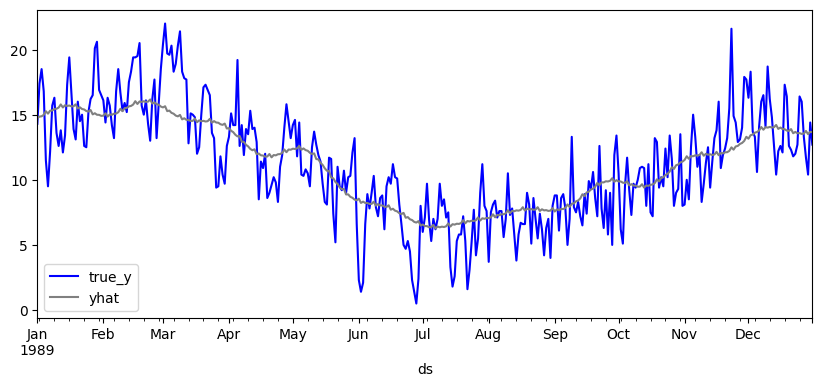

In [21]:
df_forecast_vis[['true_y','yhat']].plot(figsize = (10,4), color=['b','gray'])

<AxesSubplot: xlabel='ds'>

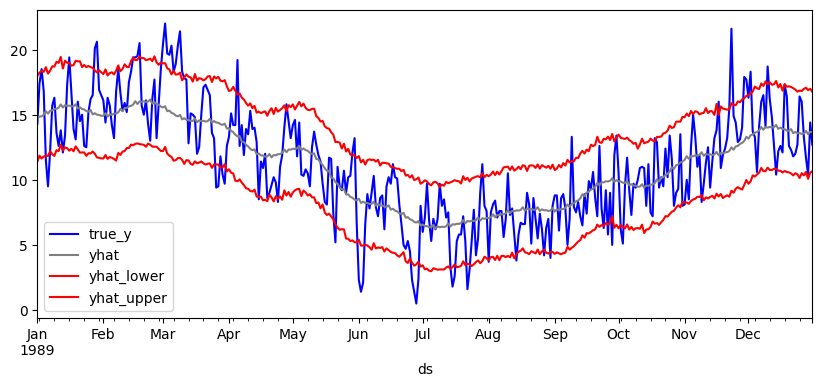

In [22]:
## visualization with range
df_forecast_vis[['true_y','yhat','yhat_lower', 'yhat_upper']].plot(figsize = (10,4), color=['b','gray','r','r'])

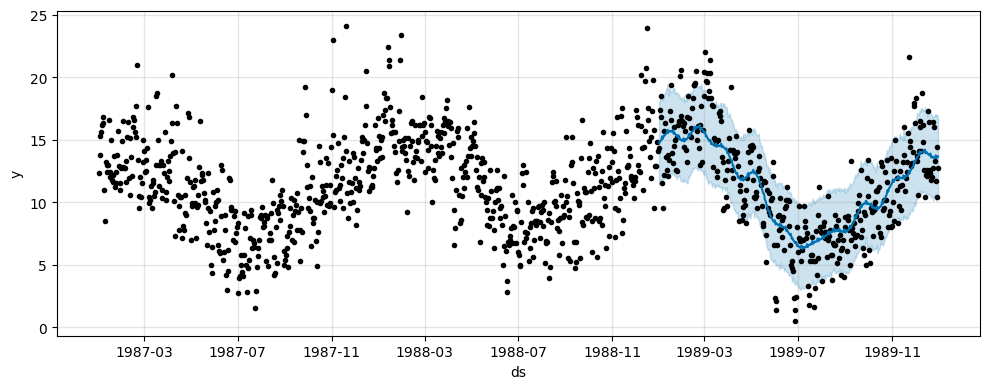

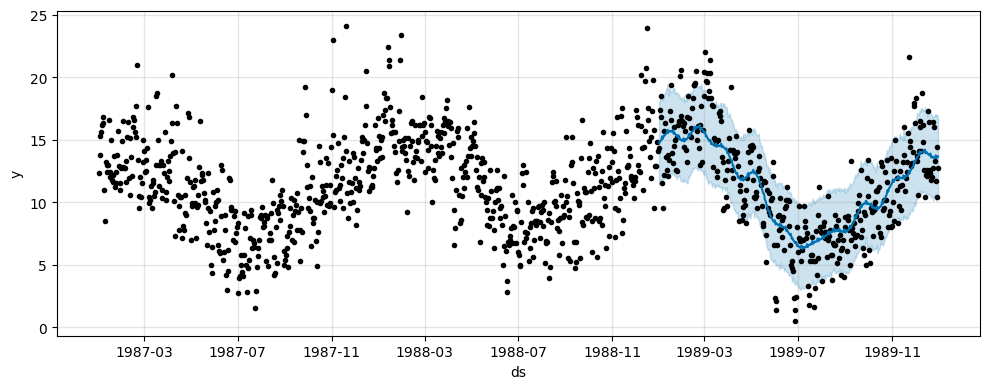

In [24]:
## or you can directly use model_ts1 to forecast

model_ts1.plot(forecast, figsize=(10,4))

## Evaluate Results

In [25]:
df_forecast.head()


,ds,yhat,yhat_lower,yhat_upper,true_y
0,1989-01-01,14.748591,11.391888,17.993869,14.3
1,1989-01-02,14.851239,11.852221,18.228695,17.4
2,1989-01-03,14.877042,11.630866,18.357944,18.5
3,1989-01-04,14.988496,11.785022,18.293413,16.8
4,1989-01-05,15.264254,11.868921,18.643863,11.5


In [26]:
eval_ts(df_forecast['true_y'],df_forecast['yhat'])

,Evaluations
mae,1.964926
mape,0.284050
mse,6.180075
rmse,2.485976


## Save model

In [27]:
joblib.dump(model_ts1,PATH_MODEL+'model_ts_v1.pkl')

['../artifacts/model_ts_v1.pkl']